NCADiffusers.ipynb, did not work. Here I try to debug what is causing it to fail
!['failure'](./Images/NCADfail.png)
From the failure, I observe that, the model seems to discretize the output. The output is not as noisy as the input. My guess is that the NCA pusheds the values of the image into extreme values. 
I want to test 2 things
* If I try without diffusion, and instead just try to create the square from any noise, will it work?
* When doing diffusion, print the noise and predicted noise side by side. Does this predicted noise also have these discretization issues?

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import diffusers
from tqdm import tqdm
from IPython.display import display, clear_output
from torchvision import transforms

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from diffusers import UNet2DModel, DDPMScheduler
from diffusers.models.embeddings import TimestepEmbedding

c:\Mine\Master\MyNca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


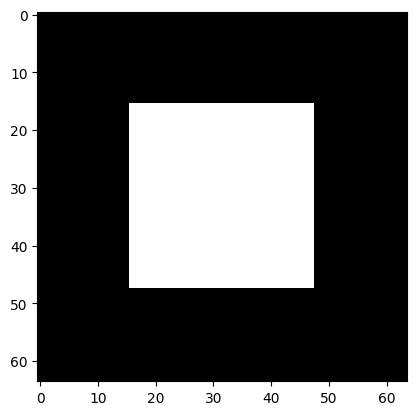

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


image_size = 64  # 64x64 pixels
# Create a single-channel image: all zeros with a white square in the middle.
image = torch.zeros((1, 1, image_size, image_size), device=device)
image[:, :, 16:48, 16:48] = 1.0

plt.imshow(image[0, 0].cpu().numpy(), cmap='gray')

In [3]:
class NCAD_Time(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(NCAD_Time, self).__init__()

        self.inchannels = in_channels
        self.outchannels = out_channels
        channelWidth = 16

        timestepEmbedSize = 32
        self.timestepEmbedding = TimestepEmbedding(in_channels=1, time_embed_dim=timestepEmbedSize)
        self.timeLin = nn.Linear(timestepEmbedSize, out_channels)
        
        self.conv1 = nn.Conv2d(in_channels, channelWidth, kernel_size=5, padding=2)  # 3x3 convolution
        self.conv2 = nn.Conv2d(channelWidth, channelWidth, kernel_size=1)
        self.conv3 = nn.Conv2d(channelWidth, channelWidth, kernel_size=1) # 1x1 convolution
        self.conv4 = nn.Conv2d(channelWidth, out_channels, kernel_size=1) # 1x1 convolution

    def forward(self, inp, t):
        bs, ch, height, width = inp.shape

        timeEmbedding = self.timestepEmbedding(t) 

        x = F.relu(self.conv1(inp))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = F.sigmoid(x)
        return x * self.timeLin(timeEmbedding) + inp * (1 - self.timeLin(timeEmbedding))
    
    def infer(self, x, steps, t):
        for i in range(steps):
            x = self.forward(x, t)
            # alpha_bar = self.get_alpha_bar(i, steps)  # Compute cumulative alpha_bar for step i
            # x = (alpha_bar ** 0.5) * x + ((1 - alpha_bar) ** 0.5) * self.forward(x, t)
        return x
    
    # def get_alpha_bar(self, i, steps):
    #     beta = torch.linspace(0.0001, 0.02, steps)  # Example linear schedule
    #     alpha = 1 - beta
    #     alpha_bar = torch.cumprod(alpha, dim=0)  # Compute cumulative product
    #     return alpha_bar[i]


# singleStepModel = NCAD_Time(1, 1).to(device)
# multiStepModel = NCAD_Time(1, 1).to(device)
timeModel = NCAD_Time(1, 1).to(device)

TimeOp = torch.optim.Adam(timeModel.parameters(), lr=1e-4)
# singleOp = torch.optim.Adam(singleStepModel.parameters(), lr=1e-4)
# multiOp = torch.optim.Adam(multiStepModel.parameters(), lr=1e-4)

diffusionSteps = 100 # ~timesteps
scheduler = DDPMScheduler(num_train_timesteps=diffusionSteps, beta_schedule='squaredcos_cap_v2')

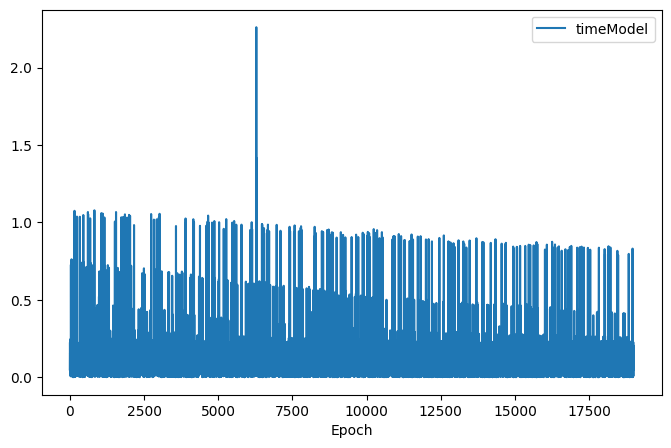

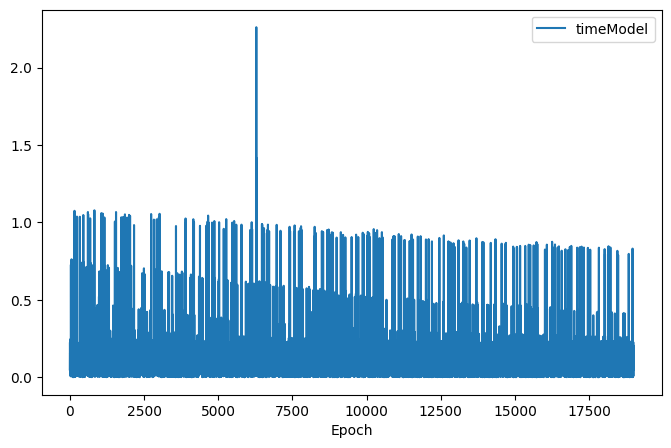

In [7]:
timeModel.train()

epochs = 20001
losses = {
    'timeModel': [],
}

fig, ax = plt.subplots(figsize=(8, 5))
display(fig)

highloss = []


for epoch in range(epochs):
    TimeOp.zero_grad()
    
    #Should try batch training
    t = torch.randint(0, diffusionSteps, (image.shape[0],), device=device).float()
    noise = torch.randn_like(image, device=device)
    noisyImage = scheduler.add_noise(image, noise, t.long())

    TimePred = timeModel.infer(noisyImage, 1, t)

    TimeLoss = F.mse_loss(TimePred, noise)
    TimeLoss.backward()
    TimeOp.step()

    # if TimeLoss.item() > 0.7:
    #     highloss.append((t, TimeLoss.item()))

    losses['timeModel'].append(TimeLoss.item())
    if epoch % 100 == 0:
        clear_output(wait=True)  
        ax.clear()
        plt.plot(losses["timeModel"][1000:], label=f'timeModel')
        plt.legend()
        plt.xlabel('Epoch')
        display(fig)
    
clear_output(wait=True)  
ax.clear()
plt.plot(losses["timeModel"][1000:], label=f'timeModel')
plt.legend()
plt.xlabel('Epoch')
display(fig)

In [202]:
highloss

[(tensor([88.], device='cuda:0'), 0.8464574813842773)]

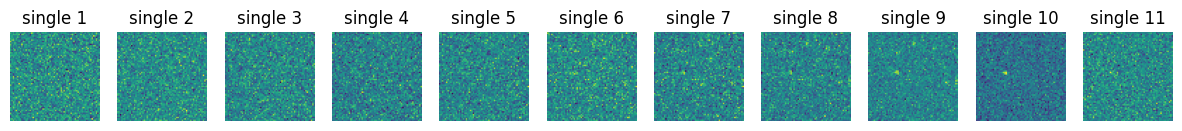

In [34]:
# Inference of trained models 

timeModel.eval()

inferenceSteps = 100
scheduler.set_timesteps(inferenceSteps)

with torch.no_grad():
    singleX = torch.randn_like(image).to(device)
    intermediateImages = {
        'single': [],
        'multi': [],
    }

    for i, t in enumerate(scheduler.timesteps):
        timeTensor = torch.tensor([t]).float().to(device)
        singleOut = timeModel.infer(singleX, 1, timeTensor)

        singleX = scheduler.step(singleOut, t, singleX).prev_sample

        if i % 10  == 0:
            intermediateImages['single'].append(singleX.cpu().numpy())
    
    #Might be a duplicate from last step
    intermediateImages['single'].append(singleX.cpu().numpy())

numColumns = len(intermediateImages['single'])
fig, axs = plt.subplots(1, numColumns, figsize=(15, 3))

# Plot images
for row, key in enumerate(['single']):
    for col, img in enumerate(intermediateImages[key]):
        axs[ col].imshow(img[0,0])
        axs[ col].axis('off')  
        axs[ col].set_title(f"{key} {col+1}")  


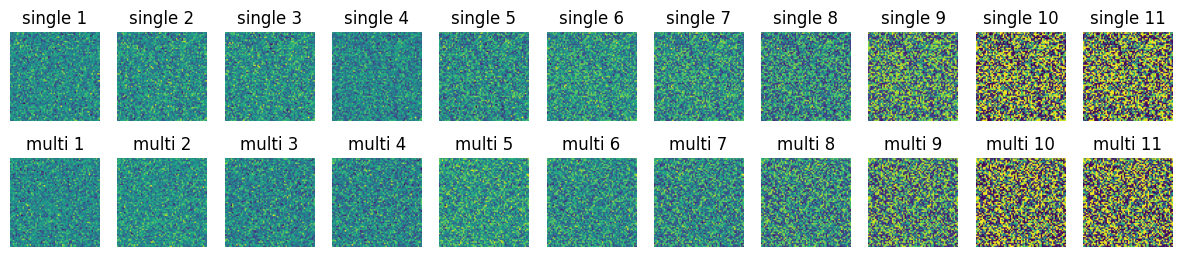

In [8]:
# Inference of trained models 

singleStepModel.eval()
multiStepModel.eval()

inferenceSteps = 20
scheduler.set_timesteps(inferenceSteps)

with torch.no_grad():
    singleX = torch.randn_like(image).to(device)
    multiX = singleX.clone()
    intermediateImages = {
        'single': [],
        'multi': [],
    }

    for i, t in enumerate(scheduler.timesteps):
        timeTensor = torch.tensor([t]).float().to(device)
        singleOut = singleStepModel.infer(singleX, 1, timeTensor)
        multiOut = multiStepModel.infer(multiX, 20, timeTensor)

        singleX = scheduler.step(singleOut, t, singleX).prev_sample
        multiX = scheduler.step(multiOut, t, multiX).prev_sample

        if i % 2:
            intermediateImages['single'].append(singleX.cpu().numpy())
            intermediateImages['multi'].append(multiX.cpu().numpy())
    
    #Might be a duplicate from last step
    intermediateImages['single'].append(singleX.cpu().numpy())
    intermediateImages['multi'].append(multiX.cpu().numpy())

numColumns = len(intermediateImages['single'])
fig, axs = plt.subplots(2, numColumns, figsize=(15, 3))

# Plot images
for row, key in enumerate(['single', 'multi']):
    for col, img in enumerate(intermediateImages[key]):
        axs[row, col].imshow(img[0,0])
        axs[row, col].axis('off')  
        axs[row, col].set_title(f"{key} {col+1}")  
